In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import os
import pickle
import gpflow

import tensorflow as tf
from sklearn.metrics import r2_score

2025-03-26 11:53:15.143765: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-26 11:53:16.154857: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743011596.442483   36893 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743011596.549314   36893 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-26 11:53:17.299596: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
import sys
sys.path.append('/glade/u/home/linnia/ctsm6_ppe/')
from utils.pyfunctions import *
utils_path = '/glade/u/home/linnia/ctsm6_ppe/utils/'

In [76]:
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
ncores=1
nmem='20GB'
cluster = PBSCluster(
    cores=ncores, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
    account='P93300041', # Input your project ID here
    walltime='02:00:00', # Amount of wall time
    #interface='ib0', # Interface to use
)

# Scale up
cluster.scale(30)

# Setup your client
client = Client(cluster)

/glade/work/linnia/conda-envs/mlenv/lib/python3.10/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33371 instead
  warnings.warn(


In [4]:
def load_NROY_samples(d,key):
    # A tree
    Atree_NROY = {}
    for b in range(1,7):
        files = np.sort(glob.glob(d+key+'_Atree*'+str(b)+'.csv'))
        Atree_NROY[biome_names[b]] = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)
    
    #Btree
    Btree_NROY = {}
    for b in [9,10,12,13]:
        files = np.sort(glob.glob(d+key+'_Btree*'+str(b)+'.csv'))
        Btree_NROY[biome_names[b]] = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)
    
    #Ctree
    Ctree_NROY = {}
    for b in [7,8,11]:
        files = np.sort(glob.glob(d+key+'_Ctree*'+str(b)+'.csv'))
        for i,f in enumerate(files):
            tmp = pd.read_csv(f)
            ix = np.random.choice(len(tmp),size=min(len(tmp),10000),replace=False)
            if i==0:
                out = tmp.iloc[ix]
            else:
                out = pd.concat([out,tmp.iloc[ix]],ignore_index=True)
        Ctree_NROY[biome_names[b]] = out

    return Atree_NROY, Btree_NROY, Ctree_NROY


In [5]:
def prune(Atree_NROY, Btree_NROY, Ctree_NROY):
    #Ctree
    b11_sample = Ctree_NROY[biome_names[11]]
    
    cols = np.concatenate((u_params, pft2_param_names,pft13_param_names))
    unique = b11_sample[cols].drop_duplicates()
    b8_sample = Ctree_NROY[biome_names[8]].merge(unique, on=cols.tolist(), how='inner')
    
    cols = np.concatenate((u_params, pft1_param_names, pft13_param_names, pft14_param_names))
    unique = b8_sample[cols].drop_duplicates()
    b7_sample = Ctree_NROY[biome_names[7]].merge(unique, on=cols.tolist(), how='inner')
    
    cols = np.concatenate((u_params, pft2_param_names, pft13_param_names))
    unique = b8_sample[cols].drop_duplicates()
    b11_sample = b11_sample.merge(unique, on=cols.tolist(), how='inner')
    
    # Btree
    cols = np.concatenate((u_params, pft2_param_names, pft12_param_names))
    unique = b11_sample[cols].drop_duplicates()
    b10_sample = Btree_NROY[biome_names[10]].merge(unique, on=cols.tolist(), how='inner')
    
    cols = np.concatenate((u_params, pft11_param_names, pft12_param_names))
    unique = b10_sample[cols].drop_duplicates()
    b9_sample = Btree_NROY[biome_names[9]].merge(unique, on=cols.tolist(), how='inner')
    b13_sample = Btree_NROY[biome_names[13]].merge(unique, on=cols.tolist(), how='inner')
    
    cols = np.concatenate((u_params, pft12_param_names))
    unique = b13_sample[cols].drop_duplicates()
    b12_sample = Btree_NROY[biome_names[12]].merge(unique, on=cols.tolist(), how='inner')

    # Atree 
    cols = np.concatenate((u_params, pft13_param_names, pft14_param_names))
    unique = b7_sample[cols].drop_duplicates()
    b4_sample = Atree_NROY[biome_names[4]].merge(unique, on=cols.tolist(), how='inner')
    b6_sample = Atree_NROY[biome_names[6]].merge(unique, on=cols.tolist(), how='inner')
    b5_sample = Atree_NROY[biome_names[5]].merge(unique, on=cols.tolist(), how='inner')
    
    cols = np.concatenate((u_params, pft14_param_names))
    unique = b5_sample[cols].drop_duplicates()
    b3_sample = Atree_NROY[biome_names[3]].merge(unique, on=cols.tolist(), how='inner')
    
    cols = np.concatenate((u_params, pft4_param_names, pft14_param_names))
    unique = b3_sample[cols].drop_duplicates()
    b2_sample = Atree_NROY[biome_names[2]].merge(unique, on=cols.tolist(), how='inner')
    
    cols = np.concatenate((u_params, pft4_param_names))
    unique = b2_sample[cols].drop_duplicates()
    b1_sample = Atree_NROY[biome_names[1]].merge(unique, on=cols.tolist(), how='inner')

    b_samples = [np.NaN,b1_sample, b2_sample, b3_sample, b4_sample, b5_sample, b6_sample, b7_sample, b8_sample,
             b9_sample, b10_sample, b11_sample, b12_sample, b13_sample]

    return b_samples

In [6]:
def build_one_sample(i,b_samples):
    # start from biome 4 and add pft 5,13,14
    r = np.random.choice(len(b_samples[4]),1)
    master = b_samples[4].iloc[r]
    
    # add pft 10 from biome 6
    cols = np.concatenate((u_params, pft13_param_names, pft14_param_names))
    tmp = b_samples[6].merge(master[cols], on=cols.tolist(), how='inner')
    r = np.random.choice(len(tmp),1)
    master= master.copy()
    master[pft10_param_names] = tmp[pft10_param_names].iloc[r].values
    
    # add pft 4 and 6 from biome 3
    cols = np.concatenate((u_params, pft14_param_names))
    tmp = b_samples[3].merge(master[cols], on=cols.tolist(), how='inner')
    r = np.random.choice(len(tmp),1)
    master.loc[:, pft4_param_names] = tmp[pft4_param_names].iloc[r].values
    master.loc[:, pft6_param_names] = tmp[pft6_param_names].iloc[r].values
    
    # add pft 7 from biome 7
    cols = np.concatenate((u_params, pft13_param_names, pft14_param_names))
    tmp = b_samples[7].merge(master[cols], on=cols.tolist(), how='inner')
    r = np.random.choice(len(tmp),1)
    master.loc[:, pft7_param_names] = tmp[pft7_param_names].iloc[r].values
    master.loc[:, pft1_param_names] = tmp[pft1_param_names].iloc[r].values
    
    # add pft 2 from biome 8
    cols = np.concatenate((u_params, pft1_param_names, pft13_param_names, pft14_param_names))
    tmp = b_samples[8].merge(master[cols], on=cols.tolist(), how='inner')
    r = np.random.choice(len(tmp),1)
    master.loc[:, pft2_param_names] = tmp[pft2_param_names].iloc[r].values
    
    # add pft 8 and 12 from biome 11
    cols = np.concatenate((u_params, pft2_param_names, pft13_param_names))
    tmp = b_samples[11].merge(master[cols], on=cols.tolist(), how='inner')
    r = np.random.choice(len(tmp),1)
    master.loc[:, pft8_param_names] = tmp[pft8_param_names].iloc[r].values
    master.loc[:, pft12_param_names] = tmp[pft12_param_names].iloc[r].values
    
    # add pft 11 from biome 10
    cols = np.concatenate((u_params, pft2_param_names, pft12_param_names))
    tmp = b_samples[10].merge(master[cols], on=cols.tolist(), how='inner')
    r = np.random.choice(len(tmp),1)
    master.loc[:, pft11_param_names] = tmp[pft11_param_names].iloc[r].values
    
    # add pft 3 from biome 9
    cols = np.concatenate((u_params, pft11_param_names, pft12_param_names))
    tmp = b_samples[9].merge(master[cols], on=cols.tolist(), how='inner')
    r = np.random.choice(len(tmp),1)
    master.loc[:, pft3_param_names] = tmp[pft3_param_names].iloc[r].values

    return master

In [67]:
import pickle

def emulate_biome(sample,biome,emulator_dir):
    with open("../biome_pft_dict.pkl", "rb") as f:
        biome_pfts = pickle.load(f)

    key = '/glade/work/linnia/CLM6-PPE/ctsm6_lhc/ctsm6lhc_11262024.txt'
    params_lhc = pd.read_csv(key).drop(columns='member')
    
    pft_params   = ['kmax','psi50','jmaxb0','slatop','lmr_intercept_atkin',
                    'medlynslope','medlynintercept','froot_leaf','leafcn','leaf_long',
                    'KCN','dleaf','r_mort','fsr_pft','xl']
    pftix=np.array([p in pft_params for p in params_lhc.columns])
    u_params = params_lhc.columns[~pftix]

    
    pfts = biome_pfts[biome]
    cols = u_params
    for p in pfts:
        param_names = [f"{param}_{p}" for param in pft_params]
        cols = np.concatenate([cols,param_names])
    
    samp = sample[cols]
    
    loaded_emulator = tf.saved_model.load(emulator_dir + biome)
    y_pred, y_pred_var = loaded_emulator.predict(samp)

    return y_pred.numpy().flatten()

### Setup

In [77]:
import pickle
with open("../biome_pft_dict.pkl", "rb") as f:
    biome_pfts = pickle.load(f)

In [78]:
file='../../../biomes/sudoku_biomes.nc'
biomes=xr.open_dataset(file)
biome_names = biomes.biome_names.values

In [79]:
obs = xr.open_dataset('../wave2_obsStatistics_sudokuBiomes.nc')

In [80]:
key = '/glade/work/linnia/CLM6-PPE/ctsm6_lhc/ctsm6lhc_11262024.txt'
params_lhc = pd.read_csv(key).drop(columns='member')

pft_params   = ['kmax','psi50','jmaxb0','slatop','lmr_intercept_atkin',
                'medlynslope','medlynintercept','froot_leaf','leafcn','leaf_long',
                'KCN','dleaf','r_mort','fsr_pft','xl']
pftix=np.array([p in pft_params for p in params_lhc.columns])
u_params = params_lhc.columns[~pftix]

In [81]:
# setup
emulator_dir = '../emulators_biomelai/'

In [82]:
pft1_param_names = [f"{param}_{1}" for param in pft_params]
pft2_param_names = [f"{param}_{2}" for param in pft_params]
pft3_param_names = [f"{param}_{3}" for param in pft_params]
pft4_param_names = [f"{param}_{4}" for param in pft_params]
pft5_param_names = [f"{param}_{5}" for param in pft_params]
pft6_param_names = [f"{param}_{6}" for param in pft_params]
pft7_param_names = [f"{param}_{7}" for param in pft_params]
pft8_param_names = [f"{param}_{8}" for param in pft_params]
pft10_param_names = [f"{param}_{10}" for param in pft_params]
pft11_param_names = [f"{param}_{11}" for param in pft_params]
pft12_param_names = [f"{param}_{12}" for param in pft_params]
pft13_param_names = [f"{param}_{13}" for param in pft_params]
pft14_param_names = [f"{param}_{14}" for param in pft_params]

### Build samples

In [83]:
### load data
d = '/glade/work/linnia/CLM6-PPE/ctsm6_wave1/NROY/'
#all_samples = []

for key in range(23,50):
    # load NROY samples
    Atree_NROY, Btree_NROY, Ctree_NROY = load_NROY_samples(d,str(key))

    # prune
    b_samples = prune(Atree_NROY, Btree_NROY, Ctree_NROY)

    # build set of random samples
    for i in range(1000): 
        out = build_one_sample(i, b_samples)  # returns a 1-row DataFrame
        all_samples.append(out)
    
samples = pd.concat(all_samples, ignore_index=True)

Exception ignored in sys.unraisablehook: <built-in function unraisablehook>
Traceback (most recent call last):
  File "/glade/work/linnia/conda-envs/mlenv/lib/python3.10/site-packages/ipykernel/iostream.py", line 684, in write
    self._buffers[frozenset(parent.items())].write(string)
KeyboardInterrupt: 

KeyboardInterrupt



In [88]:
samples = pd.concat(all_samples, ignore_index=True)

In [89]:
np.shape(samples)

(20058, 236)

In [90]:
key

23

In [85]:
samples.to_csv(d+'full_samples.csv', index=False)

### Emulate to check

In [86]:
infile = '/glade/work/linnia/CLM6-PPE/ctsm6_lhc/postp/ctsm6lhc_pxbmean_sudoku_1985-2023.nc'
ds_lhc = xr.open_dataset(infile)
lhc_pxb = ds_lhc.where(ds_lhc['crashed'] != 1, drop=True)
lai_lhc = lhc_pxb.TLAI_biome_amax.sel(year=slice('2001','2020')).mean(dim='year').compute()

2025-03-26 12:32:48.829812: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


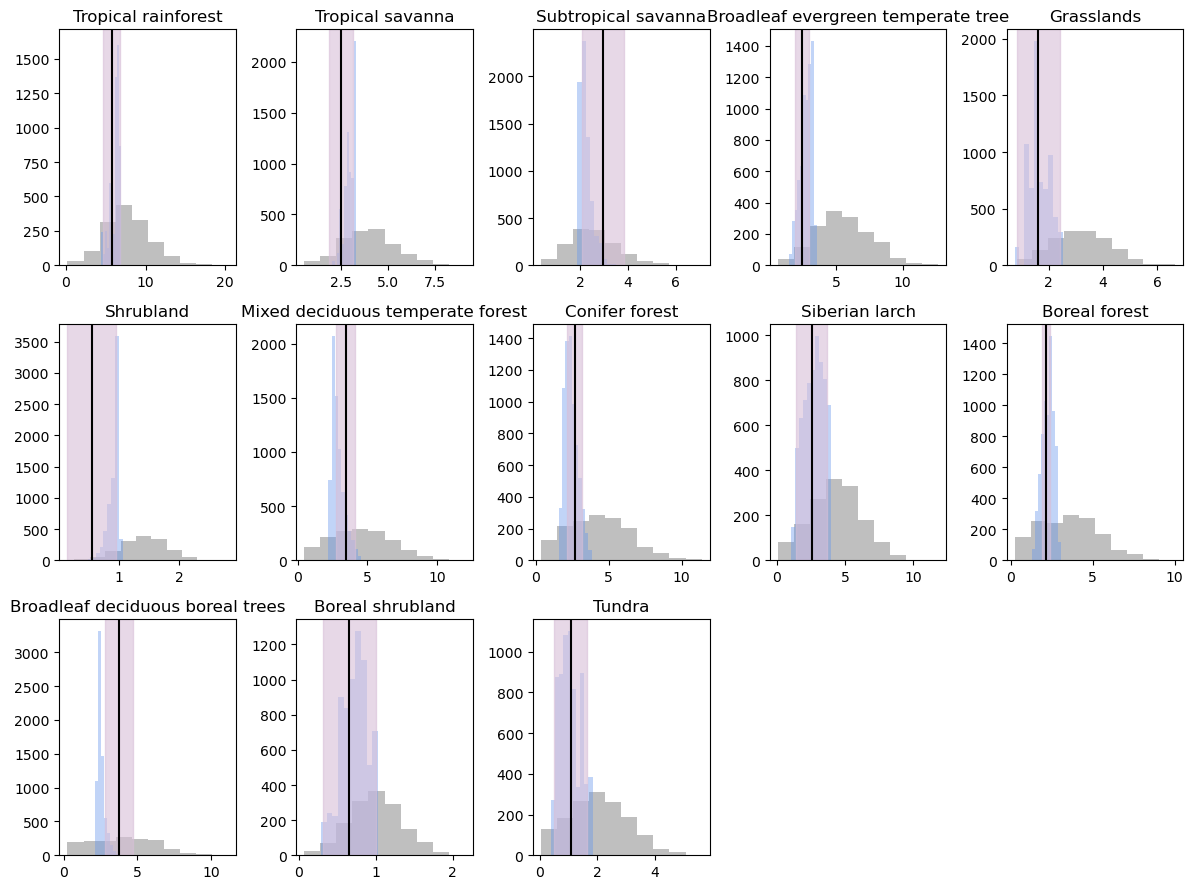

In [16]:
plt.figure(figsize=(12,9))
for b, biome in enumerate(biome_names[1:],start=1):
    plt.subplot(3,5,b)

    obs_mean = obs.LAI_mean.sel(biome=b).values
    obs_var = obs.LAI_stdev.sel(biome=b).values**2

    pfts = biome_pfts[biome]
    cols = u_params
    for p in pfts:
        param_names = [f"{param}_{p}" for param in pft_params]
        cols = np.concatenate([cols,param_names])
    
    samp = samples[cols]
    
    loaded_emulator = tf.saved_model.load(emulator_dir + biome)
    y_pred, y_pred_var = loaded_emulator.predict(samp)

    plt.hist(lai_lhc.isel(biome=b),color='grey',alpha=0.5)
    plt.hist(y_pred.numpy().flatten(),alpha = 0.4,color='cornflowerblue')
    plt.axvline(obs_mean,c='k')
    plt.axvspan(obs_mean-2*obs_var**0.5,obs_mean+2*obs_var**0.5,color='thistle',alpha=0.6)
    plt.title(biome)

plt.tight_layout()
plt.savefig('full_samples.png')

### Select best

In [93]:
# Find the best parameter set for each universal set

# find unique Universal samples
unique_usets = samples[u_params].drop_duplicates()

param_sets = np.empty((len(unique_usets),236))*np.NaN
for u in range(len(unique_usets)): # for each universal sample
    print(u)
    s = samples.merge(unique_usets.iloc[[u]], how='inner')
    biome_lai = np.empty((len(s),13))*np.NaN
    
    for b, biome in enumerate(biome_names[1:]):
        # Emulate all biomes, all rows (nrows X 13)
        y_pred = emulate_biome(s,biome,emulator_dir)
        biome_lai[:,b] = y_pred
    # score
    error = biome_lai-obs.LAI_mean.values[1:]
    rmse = np.sqrt((error**2).mean(axis=1))
    # select best
    ix = np.argmin(rmse)
    out = s.iloc[[ix]]
    
    #save
    param_sets[u,:] = out
    
df_param_sets = pd.DataFrame(param_sets,columns = samples.columns)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46


In [101]:
df_param_sets.to_csv('../params/selected_sets_v2.csv')

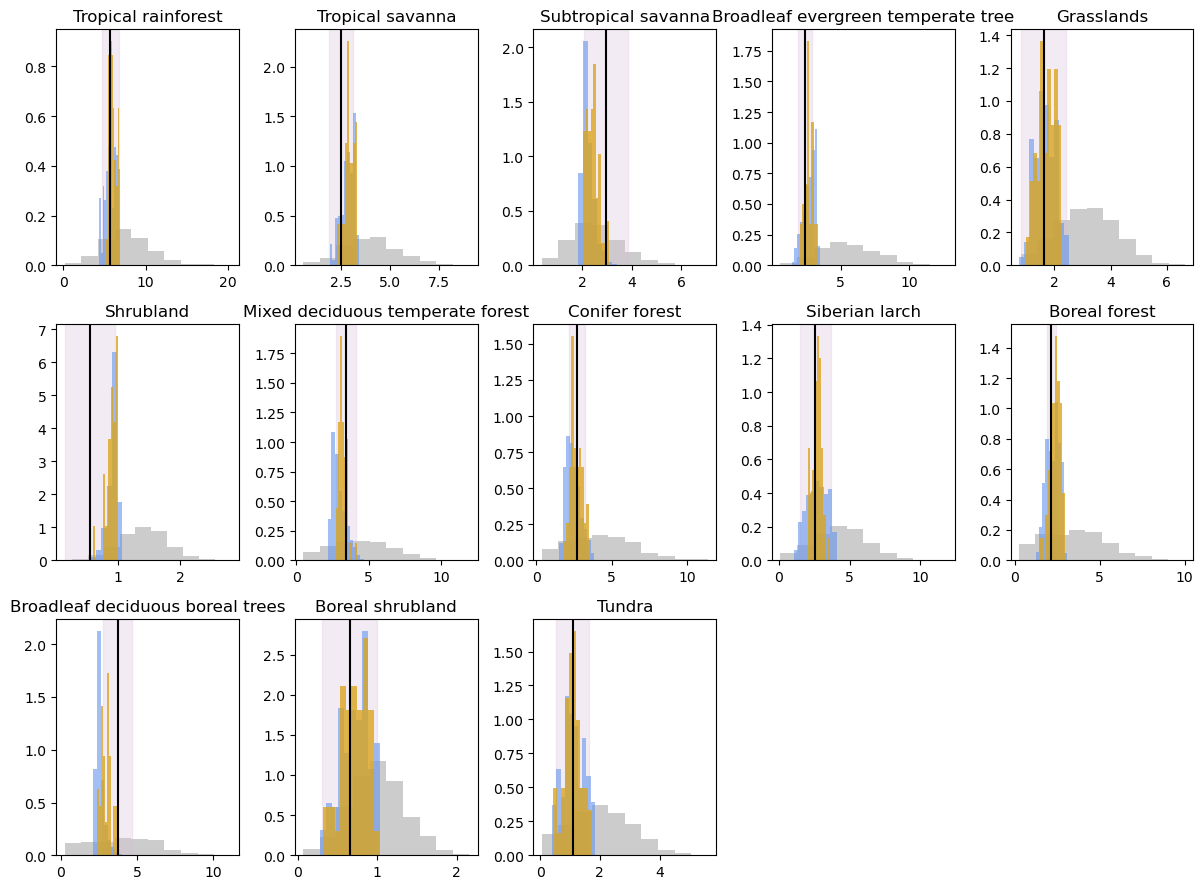

In [99]:
plt.figure(figsize=(12,9))
for b, biome in enumerate(biome_names[1:],start=1):
    plt.subplot(3,5,b)

    obs_mean = obs.LAI_mean.sel(biome=b).values
    obs_var = obs.LAI_stdev.sel(biome=b).values**2

    pfts = biome_pfts[biome]
    cols = u_params
    for p in pfts:
        param_names = [f"{param}_{p}" for param in pft_params]
        cols = np.concatenate([cols,param_names])
    
    samp = samples[cols]
    
    loaded_emulator = tf.saved_model.load(emulator_dir + biome)
    y_pred, y_pred_var = loaded_emulator.predict(samp)

    plt.hist(lai_lhc.isel(biome=b),color='grey',alpha=0.4,density=True)
    plt.axvspan(obs_mean-2*obs_var**0.5,obs_mean+2*obs_var**0.5,color='thistle',alpha=0.3)
    plt.hist(y_pred.numpy().flatten(),alpha = 0.6,color='cornflowerblue',density=True)

    # Check "best" samples
    pfts = biome_pfts[biome]
    cols = u_params
    for p in pfts:
        param_names = [f"{param}_{p}" for param in pft_params]
        cols = np.concatenate([cols,param_names])
    
    samp = df_param_sets[cols]
    
    loaded_emulator = tf.saved_model.load(emulator_dir + biome)
    y_pred, y_pred_var = loaded_emulator.predict(samp)

    plt.hist(y_pred.numpy().flatten(),alpha = 0.8,color='goldenrod',density=True)
    plt.axvline(obs_mean,c='k')
    
    plt.title(biome)

plt.tight_layout()
plt.savefig('selected_samples.png')